In [1]:
import glob, pandas, uproot, matplotlib, re
import numpy as np
from gap_statistic import OptimalK


from plotParams import varLabels, binnings, units
from clusteringTools import compute_gap
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

randomState = 1986
%matplotlib inline
import matplotlib.pyplot as plt
font = {'size':16}
matplotlib.rc('font', **font)
plt.style.use('default')


In [2]:
sigPath='/data/atlasfs02/a/users/whopkins/SheffieldNtuples_v21.2.71-SRABC-PostFAR-Signals/'

sigPaths = glob.glob(sigPath+'*TT_directTT_1300_1.*10201*p3712*')
sigPaths.extend(glob.glob(sigPath+'*TT_bWN_550_385_*10201*p3736*'))
treeName='NominalFixed'

# Only select variables that were used in the original signal regions.
from stop0L import selections
srList = ['SRATT', 'SRATW', 'SRAT0', 'SRBTT', 'SRBTW', 'SRBT0', 'SRC1_5']
splitPat = '[><=]'
allCuts = []
for sr in srList:
    allCuts.extend([re.split(splitPat, cut.replace('(', '').replace(')', ''))[0].rstrip().lstrip() for cut in selections[sr].split("*")])
branches = sorted(list(set(allCuts)))
branches.append('pT_1jet')
print(branches) 
sampLabels = []
for path in sigPaths:
    fName = path.split('/')[-1]
    
    firstSplitStr = 'directTT_';
    secondSplitStr = '.'
    if 'bWN' in fName:
        firstSplitStr = 'bWN_';
        secondSplitStr = '_Mad'
    sampLabels.append(fName.split(firstSplitStr)[1].split(secondSplitStr)[0])
print('All available variables')
print(sampLabels)
dataList = []
dataLengths = []
for path, sampName in zip(sigPaths, sampLabels):
    tree = uproot.open(path)[treeName]
    data = tree.arrays(branches, outputtype=pandas.DataFrame)
    data['sampName'] = sampName
    dataList.append(data)
    dataLengths.append(data.shape[0])
allSigs = pandas.concat(dataList)

['MS', 'MT2Chi2', 'MTbmax', 'MTbmin', 'NbV', 'NjV', 'PTISR', 'RISR', 'dRb1b2', 'dphiISRI', 'dphi_track', 'dphimin2', 'dphimin4', 'eT_miss', 'eT_miss_orig', 'eT_miss_track', 'flav_1fatjet_kt12', 'flav_2fatjet_kt12', 'm_1fatjet_kt12', 'm_1fatjet_kt8', 'm_2fatjet_kt12', 'metsigST', 'nbaselineLep', 'nj_good', 'num_bjets', 'pT_2jet', 'pT_4jet', 'pTbV1', 'pTjV4', 'passMETtriggers', 'passtauveto', 'pT_1jet']
['1300_1', '550_385']


In [3]:
rawDataPresel = allSigs[(allSigs['nbaselineLep'] ==0)]

# Make sure that all the samples have the same size.
sampNames = np.unique(rawDataPresel['sampName'])
sampSizes = {}
for sampName in sampNames:
    sampSizes[sampName] = rawDataPresel[rawDataPresel['sampName']==sampName].shape[0]
minSampSize = min(sampSizes.values())
tempDFs = [] 
for sampName in sampNames:
    tempDFs.append(rawDataPresel[rawDataPresel['sampName']==sampName].sample(minSampSize))
dataPresel = pandas.concat(tempDFs)
print(dataPresel.shape, rawDataPresel.shape, minSampSize*2)

(1182, 33) (2716, 33) 1182


In [4]:
vetoList=['passMETtriggers', 'passtauveto', 'nbaselineLep', 'eT_miss', 
          'flav_1fatjet_kt12', 'flav_2fatjet_kt12', 'num_bjets', 'NbV', 'NjV', 'nj_good']
trainBranches = [branch for branch in branches if branch not in vetoList]
print(trainBranches)
trainBranches = ['pT_1jet', 'metsigST',]


['MS', 'MT2Chi2', 'MTbmax', 'MTbmin', 'PTISR', 'RISR', 'dRb1b2', 'dphiISRI', 'dphi_track', 'dphimin2', 'dphimin4', 'eT_miss_orig', 'eT_miss_track', 'm_1fatjet_kt12', 'm_1fatjet_kt8', 'm_2fatjet_kt12', 'metsigST', 'pT_2jet', 'pT_4jet', 'pTbV1', 'pTjV4', 'pT_1jet']


['1300_1', '550_385']


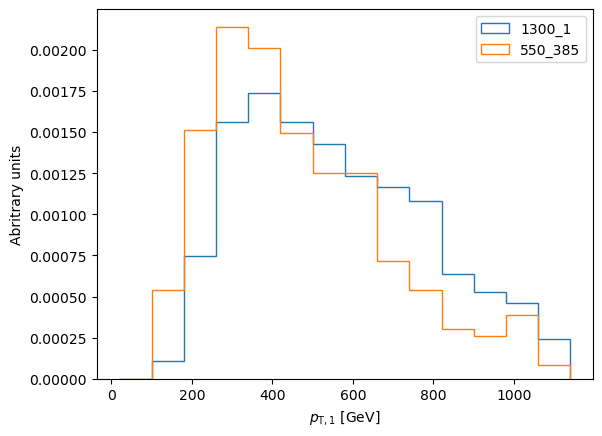

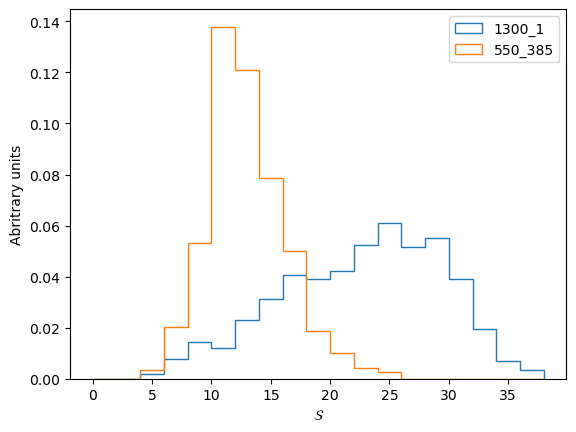

In [5]:
# Let's print these inputs for signal and background

plt.close('all')
#plt.style.use('dark_background')
for varName in trainBranches:
    fig, ax = plt.subplots()
    for samp in sampLabels[:2]:
        if varName in binnings:
            plt.hist(dataPresel[dataPresel['sampName'] == samp][varName], histtype='step', bins=binnings[varName], density=True, label=samp)
        else:
            plt.hist(dataPresel[dataPresel['sampName'] == samp][varName], histtype='step', density=True, label=samp)
        
    ax.set_ylabel('Abritrary units')
    xlabel = varName
    if varName in varLabels:
        xlabel = varLabels[varName]
        for varType in units:
            if varType in varName:
                xlabel += f' [{units[varType]}]'
                break
    ax.set_xlabel(xlabel)
    ax.legend(loc=0)
    plt.savefig(f'{varName}.pdf', bbox_inches='tight')
    plt.savefig(f'{varName}.svg', bbox_inches='tight')
print(sampLabels)

In [6]:
trainData = dataPresel[trainBranches]
scaledData = trainData.copy(deep=True)
for column in trainBranches:
    scaler = MinMaxScaler()
    scaledData[[column]] = scaler.fit_transform(trainData[[column]])

clusteringData = scaledData
minX = 0
maxX = 1
minY = 0
maxY = 1

In [7]:
k_max=20
optimalK = OptimalK(n_jobs=10)
n_clusters = optimalK(clusteringData[trainBranches].to_numpy(), cluster_array=np.arange(1, k_max+1))
#optimalK.gap_df

2


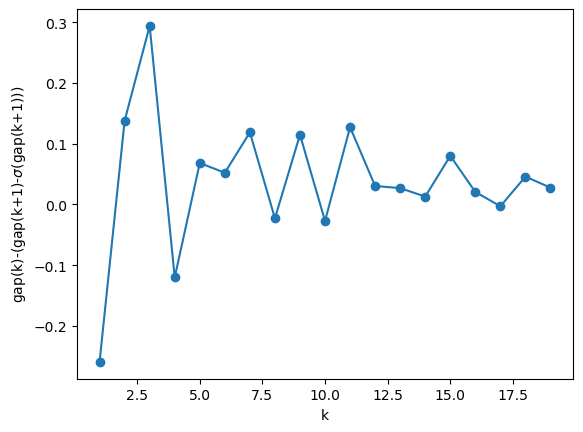

In [8]:
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap_value'], yerr=optimalK.gap_df['sk'], fmt='-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.savefig("gap_new.svg",bbox_inches='tight')
plt.savefig("gap_new.pdf",bbox_inches='tight')
fig, ax = plt.subplots()
plt.plot(range(1, k_max+1), optimalK.gap_df['diff'], '-o')
plt.ylabel('gap(k)-(gap(k+1)-$\sigma$(gap(k+1)))')
plt.xlabel('k')
plt.savefig("diff.svg",bbox_inches='tight')
plt.savefig("diff.pdf",bbox_inches='tight')
# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestK = -1;
for diffI in range(optimalK.gap_df['diff'].shape[0]):
    if optimalK.gap_df['diff'][diffI] > 0:
        bestK = diffI+1;
        break;
print(bestK)

In [9]:
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap*'], fmt='-o')
plt.ylabel('gap*')
plt.xlabel('k')
plt.savefig("gapstar.svg",bbox_inches='tight')
plt.savefig("gapstar.pdf",bbox_inches='tight')

# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestKStar = np.argmax(optimalK.gap_df['gap*'])+1
print(bestKStar)
# The gap statistics overestimates the number of clusters when there are many clusters.
if bestK >=5:
    bestK = bestKStar

1


In [10]:
bestNClus = bestK
Kmean = KMeans(n_clusters=bestNClus)
Kmean.fit(clusteringData)
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_


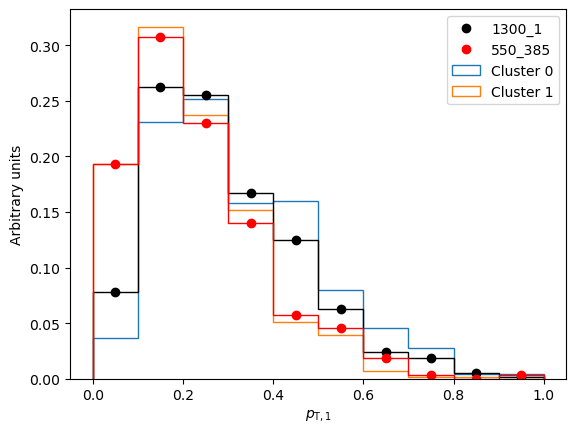

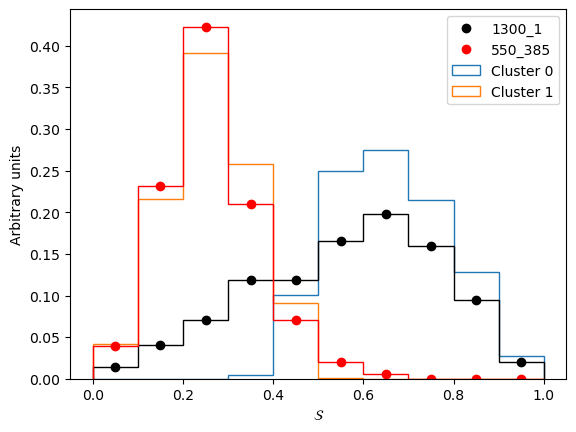

In [17]:
#plt.style.use('dark_background')
plt.style.use('default')
sampColors = ['k','r']
minFracOfTotal = 0.1
for varName in trainBranches:
    fig, ax = plt.subplots()
    for clusI in range(bestNClus):
        clusData = clusteringData[clusLabels==clusI]
        # Don't bother with clusters that are poorly represented ()
        if clusData.shape[0]/clusteringData.shape[0] < minFracOfTotal:
            continue
        plt.hist(clusData[varName], bins=[0.1*i for i in range(11)], histtype='step', weights=np.ones(clusData[varName].shape[0])/clusData[varName].shape[0], label=f"Cluster {clusI}")

    for color, sampLabel in zip(sampColors,sampLabels):
        y_values, bin_edges = np.histogram(scaledData[dataPresel.sampName==sampLabel][varName], bins=[0.1*i for i in range(11)])
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        plt.plot(bin_centers, y_values/scaledData[dataPresel.sampName==sampLabel][varName].shape[0], color+'o', label=sampLabel)
        plt.hist(scaledData[dataPresel.sampName==sampLabel][varName], bins=[0.1*i for i in range(11)], histtype='step', weights=np.ones(scaledData[dataPresel.sampName==sampLabel][varName].shape[0])/scaledData[dataPresel.sampName==sampLabel][varName].shape[0], color=color)

    xlabel = varName
    if varName in varLabels:
        xlabel = varLabels[varName]
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Arbitrary units')
    ax.legend()
    plt.savefig(f"{varName}_postclustering.svg",bbox_inches='tight')
    plt.savefig(f"{varName}_postclustering.pdf",bbox_inches='tight')

In [12]:
# Now let's plot where the clusters land on our simplified model grid
from scipy import stats

stopMasses = []
lspMasses = []
sigPointRatios = {}
sigPointMaxRatios = []
sigPointClusLabels = []
for sampLabel in sampLabels:
    stopMass, lspMass = sampLabel.split("_")
    stopMass = int(stopMass)
    lspMass = int(lspMass)
    stopMasses.append(stopMass)
    lspMasses.append(lspMass)
    
    sigPointIndex = dataPresel['sampName'] == sampLabel
    totalSigPoints = sum(sigPointIndex)
    tempSigPointSum = []
    for clusI in range(bestNClus):
        clusIndex = (clusLabels==clusI)
        
        clusSigPointIndex = clusteringData[(clusLabels==clusI) & (sigPointIndex)].shape[0]
        tempSigPointSum.append(np.sum(clusSigPointIndex))
    sigPointRatios[sampLabel] = np.array(tempSigPointSum)/totalSigPoints
    sigPointMaxRatios.append(f'{round(100*max(sigPointRatios[sampLabel])):.0f}%')
    sigPointClusLabels.append(np.argmax(sigPointRatios[sampLabel]))

fig, ax = plt.subplots()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime']
print(sigPointClusLabels)
print(sampLabels)
for i in range(len(stopMasses)):
    plt.scatter([stopMasses[i]], [lspMasses[i]], c=colors[sigPointClusLabels[i]], label=f'Cluster {sigPointClusLabels[i]}')
ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
ax.set_xlim(0,1400)
ax.set_ylim(0,700)
for i, txt in enumerate(sigPointMaxRatios):
    ax.annotate(txt, (stopMasses[i], lspMasses[i]))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig("grid_postclustering.svg",bbox_inches='tight')
plt.savefig("grid_postclustering.pdf",bbox_inches='tight')


[0, 1]
['1300_1', '550_385']
